In [1]:
import sys
sys.path
sys.path.append('../service/')

print(sys.executable)

/home/stefan/coding/notebooks/env/bin/python


In [2]:
# standart libs
import random
import copy

# 3rd party libs
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import gempy as gp
from gempy.utils import section_utils

# local
import functions as fun

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Init the geo_model

In [3]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[5, 5, 5]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


### Series

In [4]:
# set sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

In [5]:
# fun.update_series(geo_model, series_df)
# geo_model.series.df

### Surfaces

In [6]:
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

In [7]:
# gp.map_series_to_surfaces(geo_model, {"Strat_Series": ('rock2', 'rock1'), "Basement_Series": ('basement')})

In [8]:
# fun.update_surfaces(geo_model, surfaces_df)
# geo_model.surfaces.df

### Input

In [9]:
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

surface_points_input_data = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df['param1'] = 10

# Orientaions
orientations_original_df = orientaions_input_data[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [10]:
fun.set_congiguration(geo_model, geo_model_extent, section)
fun.update_series(geo_model, series_df)
fun.update_surfaces(geo_model, surfaces_df)
geo_model.set_surface_points(surface_points_original_df, update_surfaces=False)
geo_model.set_orientations(orientations_original_df, update_surfaces=False)
geo_model.update_to_interpolator()

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


True

In [11]:
fun.check_setup_single_realization(geo_model)

Run realizations setup checks until stable workflow.


In [12]:
solution = gp.compute_model(model=geo_model, sort_surfaces=False)
solution = gp.compute_model(model=geo_model, sort_surfaces=False)

/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


In [29]:
# get shape of section and test if consistent with our confiuration
section_shape = geo_model.grid.sections.resolution[0]

# get scalar field values
section_scalar_field_values = geo_model.solutions.sections[1]

# get scalar field level boundaries seperating lithologies
level = geo_model.solutions.scalar_field_at_surface_points[0]

# reshape 1D NpArray to original section shape
section_scalar_field_values_reshaped = section_scalar_field_values.reshape(section_shape).T

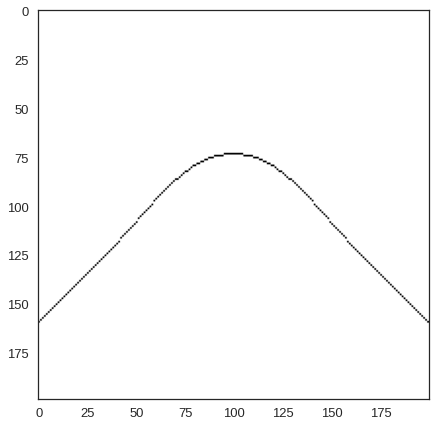

In [48]:
# find values bigger then level value x
biger_level_0 = section_scalar_field_values_reshaped > level[0]

# use matrix shifting along xaxis to find top-surface
biger_level_0_0 = biger_level_0[1:,:]
biger_level_0_1 = biger_level_0[:-1,:]
biger_level_0_i = biger_level_0_0 ^ biger_level_0_1

# plot
plt.imshow(biger_level_0_i[::-1,:])
plt.show()